In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from matplotlib.lines import Line2D
import os
import matplotlib
sns.set_style("whitegrid")

# load demographic data

In [2]:
data_dir = os.path.join('..','..','data')
# census
census = pd.read_csv(os.path.join(data_dir, 'ACS_DemHousingEst2018ACS_2018_censusEstimate.csv'))
# core sample
core_data =  pd.read_csv(os.path.join(data_dir, 'core_dem.csv'))
# excluded sample
excluded_data =  pd.read_csv(os.path.join(data_dir, 'excluded_dem.csv'))
# low completion sample
lowCompl_data =  pd.read_csv(os.path.join(data_dir, 'lowCompl_dem.csv'))

# Demographic sample summary 

In [3]:
def poli_affil(survey_data, col_name_extension = ''):
    """
    Gathers party affiliation and political leaning, and recodes semantically, 
    e.g. 1.0 -> Republican, 2.0 -> Democrat, etc
    
    Args:
        survey_data (pd.DataFrame): dataframe containing demographic raw data
        col_name_extension (string): output column name extension  (default = none)

    Returns:
        party (pd.DataFrame): party affiliation distribution in survey_data
        polit_lean (pd.DataFrame): political leaning distribution in survey_data
    """

    # Extract: DemM6-> party affiliation; DemM7-> political leaning
    survey = survey_data[['DemM6', 'DemM7']].astype(str)
    
    # column name extension 
    party_col_name = 'party'+ col_name_extension
    lean_col_name = 'polit. lean.'+ col_name_extension 
    
    # semantic recoding 
    survey = survey.rename(columns = {'DemM6': party_col_name,'DemM7': lean_col_name})
    party_names={'1.0':'Republican', '2.0':'Democrat', '3.0':'Independant', '4.0':'Other'}
    lean_names = {'1.0':'strongly liberal', '2.0':'moderately liberal', '3.0':'slightly liberal',
                 '4.0':'neutral', '5.0':'slightly conservative', '6.0':'moderately conservative', '7.0':'strongly conservative'}
    survey = survey.replace({party_col_name: party_names}) 
    survey = survey.replace({lean_col_name: lean_names}) 
    
    # party affiliation distribution in survey_data
    party = survey[party_col_name].value_counts(normalize=True) * 100
    party = party.to_frame()
    party[party_col_name] = party[party_col_name].round(decimals=2)
    # political leaning distribution in survey_data
    polit_lean = survey[lean_col_name].value_counts(normalize=True) * 100
    polit_lean = polit_lean.to_frame()
    polit_lean[lean_col_name] = polit_lean[lean_col_name].round(decimals=2)
    
    return party, polit_lean



def employment_income(survey_data, col_name_extension):
    """
    Gathers employment status  and weekly income, and recodes semantically, 
    e.g. 1.0 -> employed, 2.0 -> unemployed, etc.
    
    Args:
        survey_data (pd.DataFrame): dataframe containing demographic raw data
        col_name_extension (string): output column name extension  (default = none)

    Returns:
        employment (pd.DataFrame): employment status distribution in survey_data
        income (pd.DataFrame): income bracket distribution in survey_data
    """
    
    # Extract: DemW10_R1-> employment status; DemW18_R1-> income bracket
    survey = survey_data[['DemW10_R1', 'DemW18_R1']].astype(str)
    
    # column name extension 
    employment_name = 'employment'+ col_name_extension
    income_name = 'weekIncome'+col_name_extension 
    
    # semantic recoding 
    survey = survey.rename(columns = {'DemW10_R1': employment_name,'DemW18_R1': income_name})
    employment_names={'1.0':'employed', '2.0':'unemployed', '3.0':'retired'}
    income_names = {'1.0': 'Less than $249', '2.0' : '$250 - $499', '3.0': '$500 - $999', '4.0':'$1000 -$1499', '5.0':'$1500 - $2999', '6.0':'more than $3000', '7.0' :'Dont know'}
    survey = survey.replace({employment_name: employment_names}) 
    survey = survey.replace({income_name: income_names}) 
    
    # employment status distribution in survey_data
    employment = survey[employment_name].value_counts(normalize=True) * 100
    employment = employment.to_frame()
    employment[employment_name] = employment[employment_name].round(decimals=2)
    # income bracket distribution in survey_data
    income = survey[income_name].value_counts(normalize=True) * 100
    income = income.to_frame()
    income[income_name] = income[income_name].round(decimals=2)
    
    return employment, income


In [4]:
def get_state_data(survey_data, census_data):
    """
    Gathers state of residence distribution in census and survey data
    
    Args:
        survey_data (pd.DataFrame): dataframe containing sample demographic raw data
        census_data (string): dataframe containing census demographics
        
    Returns:
        combined (pd.DataFrame): combined state information (normalised)
    """
        
    # state dictionary
    state_dict = {'1.0': 'Alabama', '2.0': 'Alaska', '3.0': 'Arizona', '4.0': 'Arkansas', '5.0': 'California',
                  '6.0': 'Colorado', '7.0': 'Connecticut', '8.0': 'Delaware', '9.0': 'Florida', '10.0': 'Georgia',
                  '11.0': 'Hawaii', '12.0': 'Idaho', '13.0': 'Illinois', '14.0': 'Indiana', '15.0': 'Iowa', '16.0': 'Kansas',
                  '17.0': 'Kentucky', '18.0': 'Louisiana', '19.0': 'Maine', '20.0': 'Maryland', '21.0':  'Massachusetts',
                  '22.0': 'Michigan', '23.0': 'Minnesota', '24.0':  'Mississippi', '25.0' :  'Missouri', '26.0':  'Montana',
                  '27.0': 'Nebraska', '28.0': 'Nevada', '29.0':'New Hampshire', '30.0':  'New Jersey', '31.0': 'New Mexico',
                  '32.0': 'New York', '33.0': 'North Carolina', '34.0':  'North Dakota', '35.0':  'Ohio', '36.0':  'Oklahoma',
                  '37.0': 'Oregon', '38.0': 'Pennsylvania', '39.0': 'Rhode Island', '40.0':  'South Carolina',
                  '41.0': 'South Dakota', '42.0' :'Tennessee', '43.0':  'Texas', '44.0':  'Utah', '45.0':  'Vermont',
                  '46.0': 'Virginia', '47.0': 'Washington', '48.0':  'West Virginia', '49.0':  'Wisconsin', '50.0':  'Wyoming'}
    # semantic recoding 
    demW3 = survey_data['DemW3'].dropna().astype(str)
    states = demW3.replace(state_dict)
    # pop. distr. across states in survey_data
    study_states = pd.DataFrame.from_dict(dict(Counter(states)), orient='index', columns=['study'])
    study_states /= np.sum(study_states) 
    
    # organise census data
    census_states = census[['states', 'estimate_totalPop']]
    census_states.set_index('states', inplace=True)
    census_states = census_states.drop(['United States']) # remove bc not in survey data for norm
    census_states = census_states.drop(['Puerto Rico']) # remove bc not in survey data for norm
    # pop. distr. across states in census
    census_states['census'] = census_states['estimate_totalPop']/np.sum(census_states['estimate_totalPop']) # norm
    census_states.drop('estimate_totalPop', axis=1, inplace=True)
    
    # combine
    combined = census_states.merge(study_states, left_index=True, right_index=True,  how = 'outer')
    
    return combined


def get_nested_poli_data(survey_data):
    """
    Gathers nseted political affiliation data from survey 
    -> links party affiliation and political leaning 
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data for one week

    Returns:
        (pd.DataFrame): nested political information
    """
    survey = survey_data[['DemM6', 'DemM7']].astype(str)
    survey = survey.set_index('DemM6')
    
    poli = {}
    for i in set(survey.index):
        to_count = survey['DemM7'].loc[str(i)]
        if type(to_count) == str:
            to_count = [to_count]
        poli[str(i)] = dict(Counter(to_count))
        
    return poli


def get_age_sex_data(survey_data, census_data):
    """
    Gathers nested age and sex data from survey and census 
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey 
        census_data (pd.DataFrame): dataframe containing census information

    Returns:
        df (pd.DataFrame): survey data
        df2 ((pd.DataFrame): census data
        ages (list): list of age ranges as strings
    """
    
    survey_data = survey_data.set_index('PROLIFIC_PID')
    
    survey = survey_data[['prlfc_dem_age', 'DemC5']].astype(float)
    survey.columns = ['Age', 'Sex']
    bins= [i*5 for i in range(21)]
    labels = [str(i*5) + '-' + str((i+1)*5-1) for i in range(20)]

    survey['Age'] = pd.cut(survey['Age'], bins=bins, labels=labels, right=False)
    survey = survey.set_index('Age')

    ages = [value for value in labels if value in list(survey.index)]

    df_dict = {'Age':ages, 'Male':[], 'Female':[]}

    for age in ages:
        to_count = survey['Sex'].loc[age]
        if type(to_count) == np.float64:
                to_count = [to_count]
        counter = Counter(to_count)
        df_dict['Male'].append(counter[1.0])
        df_dict['Female'].append(-counter[2.0])

    df = pd.DataFrame(df_dict)
    df = df.set_index('Age')
    total = sum(df['Male']) - sum(df['Female'])
    df['Male'] = df['Male']/total * 100
    df['Female'] = df['Female']/total * 100

    males = [i for i in census_data.columns if 'estimate_male_age_' in i and 'andOver' not in i]
    females = [i for i in census_data.columns if 'estimate_female_age_' in i and 'andOver' not in i]
    ages2 = [str(i*5) + '-' + str((i+1)*5-1) for i in range(3, 17)]
    census_data = census_data.set_index('states')
    male_data = census_data[males].loc['United States'].to_list()
    female_data = [-i for i in census_data[females].loc['United States'].to_list()]
    df2 = pd.DataFrame({'Ages':ages2, 'Male':male_data, 'Female':female_data})
    total2 = sum(df2['Male']) - sum(df2['Female'])
    df2['Male'] = df2['Male']/total2 * 100
    df2['Female'] = df2['Female']/total2 * 100

    return df, df2, ages

def get_meadianAge_and_sex(survey_data):
    """
    Extract median age and sex distribution in survey data
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey 

    Returns:
        median_age (pd.DataFrame) 
        sex_perc (pd.DataFrame)
        survey (pd.DataFrame)
    """
    # organise survey data
    survey_data = survey_data.set_index('PROLIFIC_PID')
    survey = pd.DataFrame()
    survey = survey_data[['prlfc_dem_age', 'DemC5']].astype(float)
    survey.columns = ['Age', 'Sex']
    
    median_age = survey['Age'].median()
    sex_perc = sum(survey['Sex'] == 2.0)/len(survey)
    return median_age, sex_perc, survey



def get_race_data(survey_data):
    """
    Gathers race and ethnicity data from survey data
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data 

    Returns:
        (pd.DataFrame): combined race and ethnicity information
    """
    
    survey_data = survey_data.set_index('PROLIFIC_PID')
    survey = survey_data[['DemC9', 'DemC8']].astype(str)
    
    raceEth = pd.DataFrame()
    raceEth['ethnicity'] = survey['DemC8']
    raceEth['ethnicity'] = raceEth['ethnicity'].replace({'1.0': 'Hispanic or Latinx', '2.0': 'Not Hispanic or Latinx',
                                                         '3.0': 'Prefer not to disclose'})
    raceEth['race'] = survey['DemC9']
    raceEth['race'] = raceEth['race'].replace({'1.0': 'American Indian/Alaska Native', 
                                               '2.0': 'Asian', '3.0': 'Native Hawaiian or Other Pacific Islander',
                                               '4.0': 'Black or African American', '5.0': 'White', '6.0': 'Multiracial',
                                               '7.0': 'Other', '8.0': 'Prefer not to disclose'})
        
    return raceEth

# visualization

broken bar

In [5]:
def broken_bar(survey_data, census_data, ax1, ax2):
    """
    Plots a broken bar graph for two sets of data (survey and census)
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data 
        census_data (pd.DataFrame): dataframe containing census information

    Returns:
        ax1, ax2: axes of the bar graph
    """
    
    # load data and important graph values
    df = get_state_data(survey_data, census_data)
    df.loc[df['study'].isnull(), 'study'] = 0
    df.rename(columns={'study':'survey'})
    df = df.sort_values(by=['census'], ascending = False)
    max_val = df.max().max()
    cut = np.round(np.quantile(df, 0.88), 2) # 90% of values go into bottom graph
    
    ax1.set_title('Proportional Population by State')
    
    #set the y-limits on each subplot
    ax1.set_ylim(cut, max_val)
    ax2.set_ylim(0, cut)
    
    #set tick marks for upper plot 
    step1 = np.round((cut)/2, 3) 
    upper_yticks = np.arange(cut, max_val+step1, step1) 
    ax1.set_yticks(upper_yticks)
    ax1.xaxis.set_ticks_position('none') 
    ax1.tick_params(labelbottom=False) 
    
    #set ytick marks for lower plot 
    step2 = step1
    lower_yticks = np.arange(0, cut, step2)
    ax2.set_yticks(lower_yticks)
    
    #plot data into each subplot
    df.plot(y=df.columns, kind="bar", ax=ax1, width=0.8)
    df.plot(y=df.columns, kind="bar", ax=ax2, width=0.8, legend=False)
    ax1.legend(['census', 'survey'])
    #add figure labels
    ax2.set_xlabel('State')
    #fig.text(-0.01, 0.5, 'Proportion of US/study population', va='center', rotation='vertical')
    
    d = .01 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='r', clip_on=False)
    ax1.plot((-d,+d),(-d*5,+d*5), **kwargs)      # top-left diagonal
    ax1.plot((1-d,1+d),(-d*5,+d*5), **kwargs)    # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d),(1-d,1+d*2), **kwargs)   # bottom-left diagonal
    ax2.plot((1-d,1+d),(1-d,1+d*2), **kwargs) # bottom-right diagonal
    

butterfly chart

In [6]:
def age_sex_distribution(survey_data, census_data, ax):
    """
    Plots a population pyramid for survey data with overlayed census data
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data for one week
        census_data (pd.DataFrame): dataframe containing census information

    Returns:
        ax: axes of the chart
    """
    
    df, df2, ages = get_age_sex_data(survey_data, census_data)

    order = ages[::-1]

    bar_plot1 = sns.barplot(x='Male', y=df.index, data=df, order=order, lw=0, color='royalblue', alpha=0.7, ax= ax)
    bar_plot2 = sns.barplot(x='Female', y=df.index, data=df, order=order, lw=0, color='indianred', alpha=0.7, ax= ax)
    bar_plot3 = sns.barplot(x='Male', y='Ages', data=df2, order=order, lw=0, color='royalblue', alpha=0.4, ax= ax)
    bar_plot4 = sns.barplot(x='Female', y='Ages', data=df2, order=order, lw=0, color='indianred', alpha=0.4, ax= ax)

    max_val = abs(df[['Male', 'Female']]).max().max() * 1.05
    ax.set_xlim((-max_val, max_val))
    ax.set_xlabel('Percent of whole population')
    custom_lines = [Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=8),
                   Line2D([0], [0], color='indianred', alpha=0.7, linewidth=8), 
                   Line2D([0], [0], color='royalblue', alpha=0.4, linewidth=8),
                   Line2D([0], [0], color='indianred', alpha=0.4, linewidth=8)]
    custom_labels = ['Male, survey', 'Female, survey', 'Male, census', 'Female, census']
    ax.legend(custom_lines, custom_labels, loc='best')
    ax.set_title('Age distribution by sex')
    
    return df, df2

nested pie charts

In [7]:

def nested_pie_poli(survey_data, party_estimate, ax,fontsize):
    """
    Plots a nested pie chart of political affiliation and leaning 
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data 

    Returns:
        ax: axes of the pie chart
    """
    
    poli = get_nested_poli_data(survey_data)

    lean_names = {'1.0':'strongly liberal', '2.0':'moderately liberal', '3.0':'slightly liberal',
             '4.0':'neutral', '5.0':'slightly conservative', '6.0':'moderately conservative', '7.0':'strongly conservative'}
    
    # Make data
    party_names={'1.0':'Republican', '2.0':'Democrat', '3.0':'Independent', '4.0':'Other'}
    group_names = [party_names[party] for party in sorted(poli)]
    group_size=[sum(poli[i].values()) for i in sorted(poli)]

    sortd = [sorted(poli[i]) for i in sorted(poli)]
    subgroup_names = [val for sublist in sortd for val in sublist]
    subgroup_size=[poli[i][j] for i in sorted(poli) for j in sorted(poli[i])]
    
    # Create colors
    cols = [plt.cm.Reds, plt.cm.Blues, plt.cm.Purples, plt.cm.Greens]


    # First pie (outside)
    ax.axis('equal')
    nums = [[(float(i)-1)/6 for i in li] for li in sortd]
    #colours_ids = [plt.cm.Greys(nums[i][j]) for i in range(len(sortd)) for j in range(len(nums[i]))]
    colours_ids = [plt.cm.Greys(nums[i][j]*.7+.15) for i in range(len(sortd)) for j in range(len(nums[i]))]
    inner = ax.pie(subgroup_size, radius=1, colors=colours_ids, labeldistance=0.7)


    # Second pie (inside)
    colours = [cols[int(float(i))-1](0.7) for i in sorted(poli)]
    exp_colors_inner= []
    exp_colors_outer=['indianred', 'royalblue', 'mediumpurple', 'yellow']
    for i_col, _ in enumerate(exp_colors_outer):
        exp_colors_inner.append(sns.set_hls_values(matplotlib.colors.to_rgb(exp_colors_outer[i_col]),l=0.7))


    mypie, mylables,prct = ax.pie(group_size, radius=(1-0.15), labels=group_names,labeldistance=0.5, colors=exp_colors_outer,autopct='%1.1f%%',pctdistance=0.85)
    plt.setp(mypie,  edgecolor='black')
    plt.setp(mylables, fontsize= fontsize, color = 'black')
    plt.setp(prct, fontsize= fontsize, color = 'black')
    
    # third pie (inside)
    colours = [cols[int(float(i))-1](0.7) for i in sorted(poli)]
    mypie, mylables,prct = ax.pie(party_estimate['estimates'], radius=(1-0.5), labels=party_estimate['group_names'],labeldistance=0.5, colors=exp_colors_inner,autopct='%1.1f%%',pctdistance=0.85)
    plt.setp(mypie,  edgecolor='white')
    plt.setp(mylables, fontsize=fontsize, color = 'black')
    plt.setp(prct, fontsize=fontsize, color = 'black')


    custom_lines = [Line2D([0], [0], color=plt.cm.Greys(int(float(i)-1)/6), linewidth=8) for i in sorted(list(set(subgroup_names)))]
    custom_labels = [lean_names[i] for i in sorted(list(set(subgroup_names)))]
    ax.legend(custom_lines, custom_labels, loc='best')
    ax.set_title('Partisanship and Political Leaning')
    
    return poli




def nested_pie_race(survey_data, census,ax, fontsize):
    """
    Plots a nested pie chart of sample race vs census race
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data for one week
        census (pd.DataFrame): dataframe containing census data
    Returns:
        ax: axes of the pie chart
    """
    
    race = get_race_data(survey_data)
    #race.loc[race['ethnicity'] == 'Hispanic or Latinx', 'race'] = 'Hispanic or Latinx'
    
    race_names = race['race'].unique()
    
    census_race = pd.DataFrame()
    census_race['race'] = race_names 
    census_race.loc[census_race['race'] == 'White', 'count'] = census['percent_oneRace_white'].iloc[-1]
    census_race.loc[census_race['race'] == 'Black or African American', 'count'] = census['percent_oneRace_black'].iloc[-1]
    census_race.loc[census_race['race'] == 'Asian', 'count'] = census['percent_oneRace_asian'].iloc[-1]
    census_race.loc[census_race['race'] == 'American Indian/Alaska Native', 'count'] = census['percent_oneRace_nativeAm'].iloc[-1]
    census_race.loc[census_race['race'] == 'Native Hawaiian or Other Pacific Islander', 'count'] = census['percent_oneRace_pacificIsl'].iloc[-1]
    census_race.loc[census_race['race'] == 'Other', 'count'] = census['percent_oneRace_other'].iloc[-1]
    census_race.loc[census_race['race'] == 'Multiracial', 'count'] = census['percent_more1race'].iloc[-1]
    census_race.loc[census_race['count'].isnull(), 'count'] = 0
    census_race = census_race.sort_values(by = 'race')
   
    exp_colors_outer = ['DarkViolet',  'SteelBlue','Lightcoral', 'MediumVioletRed','MediumSeaGreen',
             'MediumPurple', 'Orange','DarkCyan','FireBrick' ]
    
    exp_colors_inner= []
    for i_col, _ in enumerate(exp_colors_outer):
        exp_colors_inner.append(sns.set_hls_values(matplotlib.colors.to_rgb(exp_colors_outer[i_col]),l=0.7))


    
 
    mypie, mylables,prct = ax.pie((race.groupby('race').race.count()/len(race))*100, radius=1, labeldistance=0.7, colors = exp_colors_outer, labels = race.race.value_counts().index,autopct='%1.1f%%',pctdistance=0.85)
    plt.setp(mypie,  edgecolor='black')
    plt.setp(mylables, fontsize= fontsize, color = 'black')
    plt.setp(prct, fontsize= fontsize, color = 'black')
    mypie, mylables,prct = ax.pie(census_race['count'], radius=0.5, labeldistance=0.7, colors = exp_colors_inner, labels = census_race['race'],autopct='%1.1f%%',pctdistance=0.85)
    plt.setp(mypie,  edgecolor='white')
    plt.setp(mylables, fontsize=fontsize, color = 'black')
    plt.setp(prct, fontsize=fontsize, color = 'black')
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)

    return census_race, race

def nested_pie_ethnicity(survey_data, census,ax, fontsize):
    """
    Plots a nested pie chart of sample ethnicity vs census ethnicity
    
    Args:
        survey_data (pd.DataFrame): dataframe containing survey data for one week
        census (pd.DataFrame): dataframe containing census data
    Returns:
        ax: axes of the pie chart
    """
    
    race = get_race_data(survey_data)
    
    eth_names = race['ethnicity'].unique()
   
    census_eth = pd.DataFrame()
    census_eth['ethnicity'] = eth_names
    census_eth.loc[census_eth['ethnicity'] == 'Hispanic or Latinx', 'count'] =census['percent_HispOrLat'].iloc[-1]
    census_eth.loc[census_eth['ethnicity'] == 'Not Hispanic or Latinx', 'count'] =census['percent_NotHispOrLat'].iloc[-1]
    census_eth.loc[census_eth['count'].isnull(), 'count'] = 0

    ax.axis('equal')
    
    exp_colors_outer = ['MediumVioletRed','Gold', 'RoyalBlue']
    exp_colors_inner= []
    for i_col, _ in enumerate(exp_colors_outer):
        exp_colors_inner.append(sns.set_hls_values(matplotlib.colors.to_rgb(exp_colors_outer[i_col]),l=0.7))

    mypie, mylables,prct = ax.pie(race.ethnicity.value_counts(), radius=1, labeldistance=0.7, colors = exp_colors_outer, 
                                  labels = eth_names,autopct='%1.1f%%',pctdistance=0.85)
    plt.setp(mypie,  edgecolor='black')
    plt.setp(mylables, fontsize= fontsize, color = 'black')
    plt.setp(prct, fontsize= fontsize, color = 'black')
    mypie, mylables,prct = ax.pie(census_eth['count'], radius=0.5, labeldistance=0.7, colors = exp_colors_inner, 
                                  labels = census_eth['ethnicity'],autopct='%1.1f%%',pctdistance=0.85,textprops={'size': 'x-large'})
    plt.setp(mypie,  edgecolor='white')
    plt.setp(mylables, fontsize=fontsize, color = 'black')
    plt.setp(prct, fontsize=fontsize, color = 'black')

    fig.tight_layout()
    fig.subplots_adjust(top=0.93)

    return race


# figure: demographics  of core sample

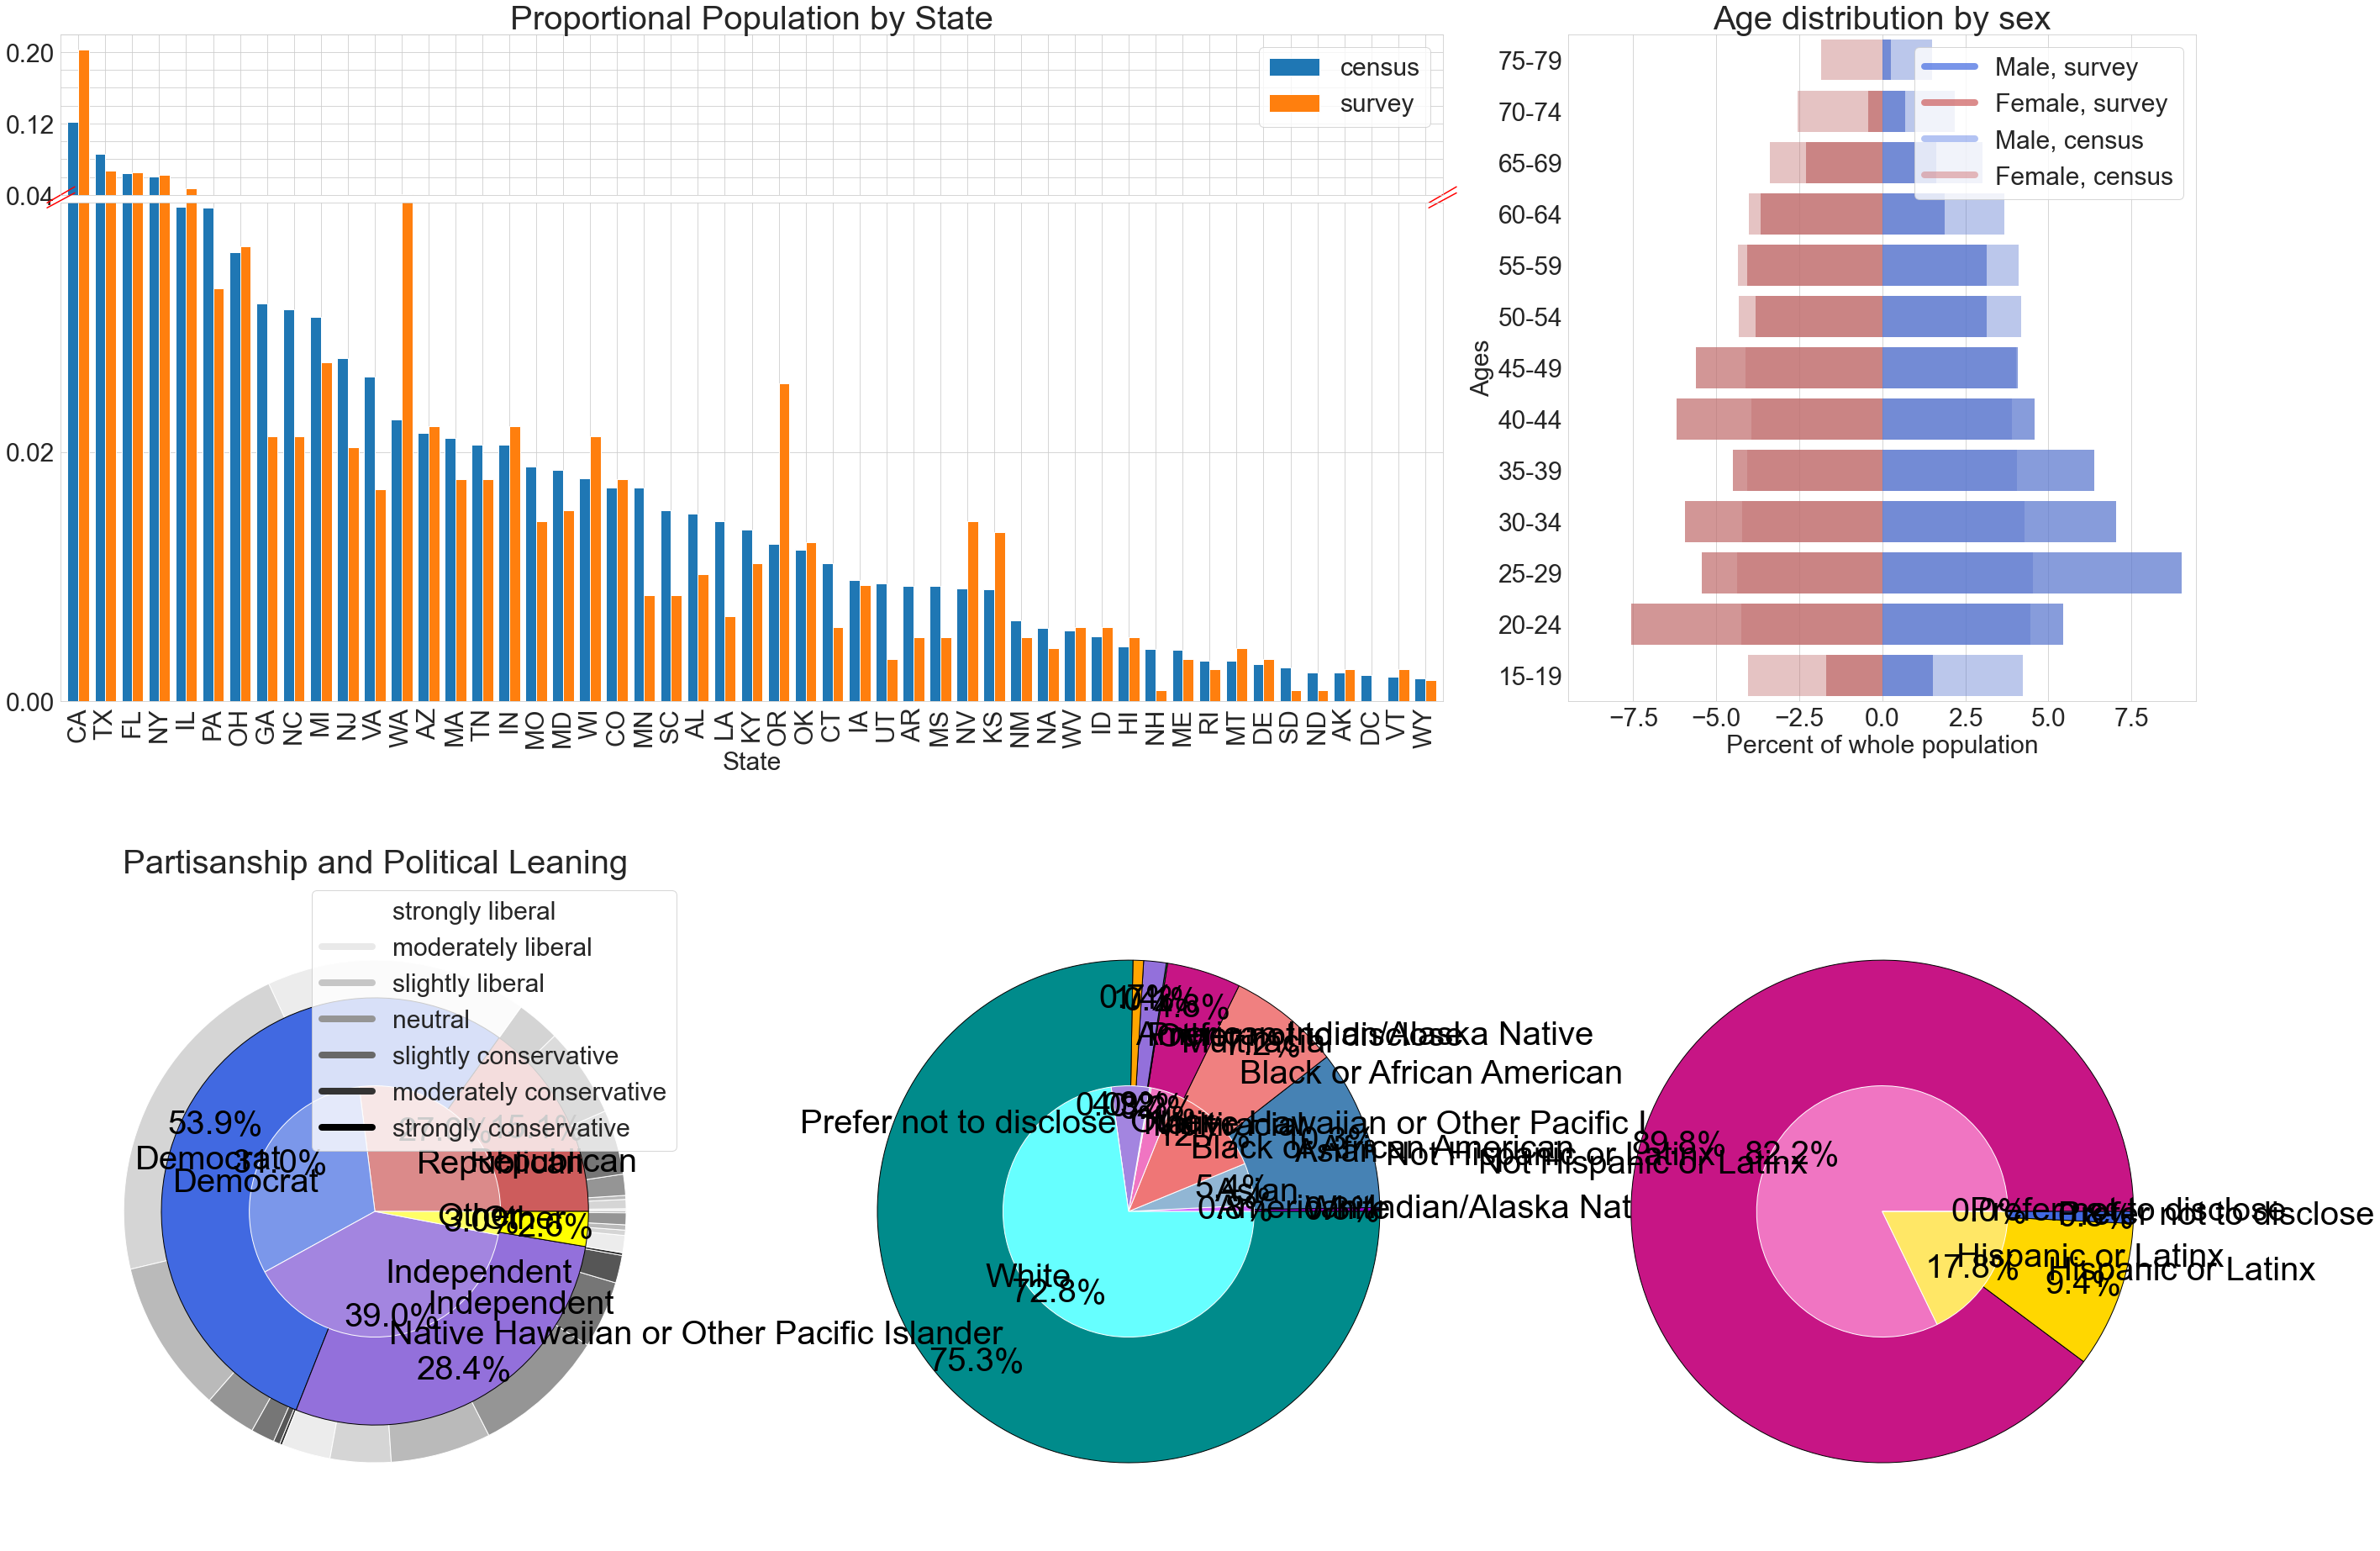

In [8]:
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title

fig = plt.figure(figsize=(40, 30))

gs = fig.add_gridspec(10,3)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[1:4, :2])
ax3 = fig.add_subplot(gs[:4, 2])
ax4 = fig.add_subplot(gs[5:9, 0])
ax5 = fig.add_subplot(gs[5:9, 1])
ax6 = fig.add_subplot(gs[5:9, 2])

####### state of residence ######
broken_bar(core_data, census, ax1, ax2)
ax1.set_yticklabels(['0.04','', '','','0.12','','','','0.20',''])
 # state dictionary
state_dict = {'Alabama':'AL',  'Alaska':'AK',  'Arizona': 'AZ', 'Arkansas': 'AR', 'California':'CA',
            'Colorado': 'CO', 'Connecticut':'CT','District of Columbia':'DC', 'Delaware': 'DE', 'Florida':'FL','Georgia':'GA',
            'Hawaii':'HI', 'Idaho':'ID', 'Illinois':'IL',  'Indiana': 'IN',  'Iowa':'IA',  'Kansas':'KS',
            'Kentucky':'KY', 'Louisiana':'LA', 'Maine':'ME', 'Maryland':'MD',  'Massachusetts':'MA',
            'Michigan':'MI', 'Minnesota':'MN', 'Mississippi':'MS' , 'Missouri': 'MO',  'Montana':'MT',
            'Nebraska':'NA','Nevada':'NV', 'New Hampshire':'NH', 'New Jersey':'NJ', 'New Mexico':'NM',
            'New York':'NY','North Carolina':'NC',  'North Dakota':'ND', 'Ohio':'OH', 'Oklahoma':'OK',
            'Oregon':'OR', 'Pennsylvania':'PA', 'Rhode Island':'RI',  'South Carolina':'SC',
            'South Dakota':'SD', 'Tennessee':'TN', 'Texas':'TX', 'Utah':'UT', 'Vermont':'VT',
            'Virginia':'VA',  'Washington':'WA',  'West Virginia':'WV',  'Wisconsin':'WI', 'Wyoming':'WY'}
ax_xlables = ax2.get_xticklabels()
new_lables = []
for idx  in range(len(ax_xlables)):
    new_lables.append(state_dict[ax_xlables[idx].get_text()])
ax2.set_xticklabels(new_lables)

#### page and sex #######
age_surv, age_cens = age_sex_distribution(core_data, census, ax3)

#### political affiliation #######
# estimates taken from: https://news.gallup.com/poll/15370/party-affiliation.aspx
party_estimates = pd.DataFrame()
party_estimates['estimates'] = [27,31, 39,3]
party_estimates['group_names'] = ['Republican', 'Democrat', 'Independent', 'Other']
poli = nested_pie_poli(core_data, party_estimates, ax4,40)


#### race and ethnicity #########
census_race, race = mylables = nested_pie_race(core_data, census, ax5,  40)
eth = nested_pie_ethnicity(core_data, census, ax6,40)


# save as svg
fig.subplots_adjust(wspace=0.2, hspace=0.05)
plt.savefig(os.path.join('imgs', 'demw1-16.svg'))

